#### Reading the csv dataset file into a pandas dataframe

In [163]:
import pandas as pd
dataset_df=pd.read_csv('housing.csv') #reading the dataset 
print(dataset_df.shape)
dataset_df.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Data Pre-processing measures

In [165]:
dataset_df.drop('ocean_proximity',axis=1,inplace=True)#removing the ocean proximity column
dataset_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


#### Applying z-score normalization

In [167]:
#now applying z-score normalization to all columns
for col in dataset_df.columns:
    sd=dataset_df[col].std() #standard deviation per column
    mean_df=dataset_df[col].mean() #mean calculated per column(Series)
    dataset_df[col]=(dataset_df[col]-mean_df)/sd #z score normalized values via vectorization
    
dataset_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.327803,1.052523,0.982119,-0.804800,-0.970301,-0.974405,-0.977009,2.344709,2.129580
1,-1.322812,1.043159,-0.607004,2.045841,1.348243,0.861418,1.669921,2.332181,1.314124
2,-1.332794,1.038478,1.856137,-0.535733,-0.825541,-0.820757,-0.843616,1.782656,1.258663
3,-1.337785,1.038478,1.856137,-0.624199,-0.718750,-0.766010,-0.733764,0.932945,1.165072
4,-1.337785,1.038478,1.856137,-0.462393,-0.611959,-0.759828,-0.629142,-0.012881,1.172871


#### Preparing the dataset for the first two approaches

In [169]:
import math
#Dividing the dataframe into three parts- training, cross validation and testing dataset
#55%-training samples excluding validation and testing
#25%-validation set
#20%-testing samples
#Introduce randomization
dataset_df = dataset_df.dropna().sample(frac=1, random_state=42).reset_index(drop=True)

rows = len(dataset_df)

n_train = math.floor(0.55 * rows)

n_val = math.floor(0.25 * rows)

train_df=pd.DataFrame(dataset_df.iloc[0:n_train,:]) #creating the training dataset exculding the validation set(55%)

val_df=pd.DataFrame(dataset_df.iloc[n_train:n_train+n_val,:]) #creating the validation dataset(25%)

test_df=pd.DataFrame(dataset_df.iloc[n_val+n_train:,:]) #creating the testing dataset(20%)

y_obs_train=train_df['median_house_value'].values #actual values for training dataset

y_obs_val=val_df['median_house_value'].values #actual values for validation dataset

y_obs_test=test_df['median_house_value'].values #actual values for testing dataset

train_df.drop('median_house_value',axis=1,inplace=True)

val_df.drop('median_house_value',axis=1,inplace=True)

test_df.drop('median_house_value',axis=1,inplace=True)

print(train_df.head())

print(val_df.head())

print(test_df.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0   1.162799 -1.330489           -0.686460    -0.767671       -0.616706   
1  -0.858632  1.113386           -2.116671     1.726811        1.371974   
2   0.713592 -0.801451            0.187557     0.502030        0.747842   
3  -1.247944  1.080613            0.108101    -0.630617       -0.621452   
4  -1.158103  1.104022           -1.957759    -0.213036        0.140322   

   population  households  median_income  
0   -0.795150   -0.642220      -0.361545  
1    1.679105    1.196507       0.324467  
2    0.783711    0.788483      -0.340543  
3   -0.634438   -0.728533      -0.515138  
4   -0.439288   -0.100802       0.121553  
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
11238   1.991336 -1.321126           -1.878303    -0.839178       -0.937078   
11239  -0.883587  1.422381            0.425926    -0.519231       -0.649929   
11240   1.287579 -1.016812           -1.242653    -0.4

### Approach 1-Pure Python Implementation without Numpy(using pandas)

In [171]:
import math
import time

epochs=2000
alpha_lr=0.03

weight_vector=[0.55555556 for i in range(train_df.shape[1])] #initialization of the weight vector via list comprehension(for faster internal computation)

feature_matrix=[]
for i in range(train_df.shape[0]):
    h=[]
    for j in range(8):
        h.append(train_df.iat[i,j]) #creating matrix of all feature values from the pandas dataframe
    feature_matrix.append(h)

bias_scaler=0.55555556 #initial value of bias

train_samples=train_df.shape[0]

start_time=time.time() #before starting the epochs

sum_avg=0

cost_func=[] #keep track of values of cost function at beginning of every iteration

for i in range(epochs):
    y_pred=[]
    for j in range(train_df.shape[0]):
        sum=0
        for q in range(train_df.shape[1]):
            sum+=weight_vector[q]*feature_matrix[j][q]+bias_scaler #first calculating the predicted value for every training sample
        y_pred.append(sum)
    mse_loss=0
    for j in range(train_df.shape[0]):
        mse_loss+=(y_pred[j]-y_obs_train[j])**2 #calculating value of the cost function for each epoch
    mse_loss/=train_df.shape[0]
    cost_func.append(mse_loss)# appending to the list to keep track for creating a plot at the end
    grad_weights=[] #to store gradient values for weight corresponding to every feature
    bias_grad=0 # to store gradient value for the bias
    for t in range(train_df.shape[1]):
        sum=0
        sigma_error=0
        for h in range(train_df.shape[0]):
            sum+=(y_pred[h]-y_obs_train[h])*feature_matrix[h][t]
            sigma_error+=y_pred[h]-y_obs_train[h]
        grad_weights.append(sum/train_samples) #gradient value for each weight for mean cost function
        bias_grad=sigma_error/train_samples
    bias_scaler-=alpha_lr*bias_grad
    for q in range(train_df.shape[1]):
        weight_vector[q]-=alpha_lr*grad_weights[q] #final updation of each weight
        
end_time=time.time()

print(f"Time for training: {(end_time-start_time):0.4f} seconds") #total training time

time_1=(end_time-start_time);

feature_matrix_val=[]
for i in range(val_df.shape[0]):
    h=[]
    for j in range(8):
        h.append(val_df.iat[i,j])
    feature_matrix_val.append(h) #feature matrix for validation set
y_pred_val=[]
for j in range(val_df.shape[0]):
    sum=0
    for q in range(val_df.shape[1]):
        sum+=weight_vector[q]*feature_matrix_val[j][q] #predicted value for validation set as per the determined weight list
    sum+=bias_scaler
    y_pred_val.append(sum)

#MSE Loss Computation over validation set
mse_loss=0
for j in range(val_df.shape[0]):
    mse_loss+=(y_pred_val[j]-y_obs_val[j])**2 
mse_loss/=val_df.shape[0]

rmse_loss=math.sqrt(mse_loss) #RMSE loss computation over validation set

#R2 score computation over validation set
sum=0
for t in range(val_df.shape[0]):
    sum+=y_obs_val[t]
sum/=val_df.shape[0]
rss=0
sss=0
for t in range(val_df.shape[0]):
    rss+=(y_pred_val[t]-y_obs_val[t])**2
    sss+=(y_obs_val[t]-sum)**2

r2_score_val=1-rss/sss

print(f"MSE loss over validation set: {mse_loss:0.2f}")
print(f"RMSE loss over validation set: {rmse_loss:0.2f}")
print(f"R2 Score over validation set: {r2_score_val:0.2f}")

feature_matrix_test=[] 
for i in range(test_df.shape[0]):
    h=[]
    for j in range(8):
        h.append(test_df.iat[i,j])
    feature_matrix_test.append(h) #feature matrix for test dataset
y_pred_test=[]
for j in range(test_df.shape[0]):
    sum=0
    for q in range(test_df.shape[1]):
        sum+=weight_vector[q]*feature_matrix_test[j][q] #predicted value for every test sample
    sum+=bias_scaler
    y_pred_test.append(sum)

#MSE Loss Computation over validation set
mse_loss_test_1=0
for j in range(test_df.shape[0]):
    mse_loss_test_1+=(y_pred_test[j]-y_obs_test[j])**2
mse_loss_test_1/=test_df.shape[0]

rmse_loss_test_1=math.sqrt(mse_loss_test) #RMSE loss computation over validation set

#R2 score computation over validation set
sum_test=0
for t in range(test_df.shape[0]):
    sum_test+=y_obs_test[t]
sum_test/=test_df.shape[0]
rss_test=0
sss_test=0
for t in range(test_df.shape[0]):
    rss_test+=(y_pred_test[t]-y_obs_test[t])**2
    sss_test+=(y_obs_test[t]-sum_test)**2

r2_score_test_1=1-rss_test/sss_test

print(f"MSE loss over test set: {mse_loss_test_1:0.2f}")
print(f"RMSE loss over test set: {rmse_loss_test_1:0.2f}")
print(f"R2 Score over test set: {r2_score_test_1:0.2f}")

Time for training: 151.2019 seconds
MSE loss over validation set: 0.38
RMSE loss over validation set: 0.62
R2 Score over validation set: 0.63
MSE loss over test set: 0.36
RMSE loss over test set: 0.61
R2 Score over test set: 0.64


### Approach 2- Using Numpy optimization

In [173]:
#performing multivariable linear regression
import math 
import numpy as np
import time

epochs=2000
alpha_lr=0.03
weight_vector=np.full((train_df.shape[1],),0.55555556) #initialization same as approach 1

feature_matrix=train_df.iloc[:,:8].values
bias_scaler=0.55555556 #initialization same as approach 1

train_samples=train_df.shape[0]

start_time=time.time()

sum_avg=0

cost_func_2=[] #to keep track of the cost function with every epoch

for i in range(epochs):
    beg_sec=time.time()
    y_pred_train=np.dot(feature_matrix,weight_vector)+bias_scaler #calculation of the vector of predicted values via w.x
    cost_func_2.append(np.mean(np.square(y_pred_train-y_obs_train))) #calculation of cost for every epoch
    error=y_pred_train-y_obs_train
    grad_w=(np.dot(feature_matrix.T,error)/train_samples)*alpha_lr #gradient vector for weights calculated using mean squared gradient formula and vectorization
    grad_b=(np.sum(error)/train_samples)*alpha_lr #gradient value for bias calculated using numpy methods
    weight_vector=weight_vector-grad_w #weight vector updated in one go via vectorization
    bias_scaler=bias_scaler-grad_b #update of bias
    end_sec=time.time()
    sum_avg+=end_sec-beg_sec

end_time=time.time()

sum_avg/=epochs

print(f"Average time taken per epoch for calculating gradients and updating weights and bias using parallelization: {sum_avg:0.6f} seconds")
print(f"Converging time: {(end_time-start_time):0.2f} seconds")

time_2=end_time-start_time

feature_matrix_val=val_df.iloc[:,:8].values #feature matrix for validation set

y_pred_val=np.dot(feature_matrix_val,weight_vector)+bias_scaler #predicted values for validation set

y_mean_ac_val=np.mean(y_obs_val)

rmse_loss_val=math.sqrt(np.mean(np.square(y_pred_val-y_obs_val))) #rmse loss over validation set

mse_loss_val=np.mean(np.square(y_pred_val-y_obs_val)) #mse loss over validation set

r_score_val=1-(np.sum(np.square(y_pred_val-y_obs_val))/(np.sum(np.square(y_obs_val-y_mean_ac_val)))) #r2 score over validation set

print(f"Loss(RMSE) for validation set is: {rmse_loss_val:0.2f}")
print(f"Loss(MSE) for validation set is : {mse_loss_val:0.2f}")
print(f"R^2 Score for validation set is: {r_score_val:0.2f}")

feature_matrix_test=test_df.iloc[:,:8].values #feature matrix for test dataset
y_pred_test=np.dot(feature_matrix_test,weight_vector)+bias_scaler #predicted values for testing samples

y_mean_ac_test=np.mean(y_obs_test)

rmse_loss_test_2=math.sqrt(np.mean(np.square(y_pred_test-y_obs_test))) #rmse value for test dataset

mse_loss_test_2=np.mean(np.square(y_pred_test-y_obs_test)) #mse over test dataset

r_score_test_2=1-(np.sum(np.square(y_pred_test-y_obs_test))/(np.sum(np.square(y_obs_test-y_mean_ac_test)))) #r2 score over test dataset

print(f"Loss(RMSE) for test set is: {rmse_loss_test_2:0.2f}")
print(f"Loss(MSE) for test set is : {mse_loss_test_2:0.2f}")
print(f"R^2 Score for test set is: {r_score_test_2:0.2f}")

Average time taken per epoch for calculating gradients and updating weights and bias using parallelization: 0.000402 seconds
Converging time: 0.81 seconds
Loss(RMSE) for validation set is: 0.62
Loss(MSE) for validation set is : 0.39
R^2 Score for validation set is: 0.63
Loss(RMSE) for test set is: 0.60
Loss(MSE) for test set is : 0.36
R^2 Score for test set is: 0.64


### Approach 3- Using Scikit Learn library

In [175]:
import time
import math
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score

X_train,X_test,y_train,y_test=train_test_split(dataset_df.iloc[:,:8],dataset_df.iloc[:,8:9],test_size=0.2,random_state=42) #splitting into testing and training samples

y_train=y_train.values
y_test=y_test.values

model_linear=LinearRegression() #Linear Regression model created

start_time=time.time()

model_linear.fit(X_train,y_train)

end_time=time.time()

print(f"Time required to fit the model to training data: {(end_time-start_time):0.6f} seconds") #fitting time

time_3=end_time-start_time

kfold=KFold(n_splits=5,shuffle=True,random_state=42)

cross_val_scores=cross_val_score(model_linear,X_train,y_train,cv=kfold,scoring='r2') #cross validation applied for 5 folds of training data

print(f"Average Cross validation score: {np.mean(cross_val_scores):0.2f}")

y_pred=model_linear.predict(X_test) #predicted values over test data

mse_loss_3=mean_squared_error(y_test,y_pred) #mse over test data

rmse_loss_3=np.sqrt(mse_loss) #rmse over test data

r2_score_val_3=r2_score(y_test,y_pred) #r2 score over test data

print(f"MSE Loss on test data: {mse_loss_3:0.2f}")
print(f"RMSE Loss on test data: {rmse_loss_3:0.2f}")
print(f"R2 score on test data: {r2_score_val_3:0.2f}")

Time required to fit the model to training data: 0.009999 seconds
Average Cross validation score: 0.63
MSE Loss on test data: 0.36
RMSE Loss on test data: 0.62
R2 score on test data: 0.65


### Scrutiny of all approaches

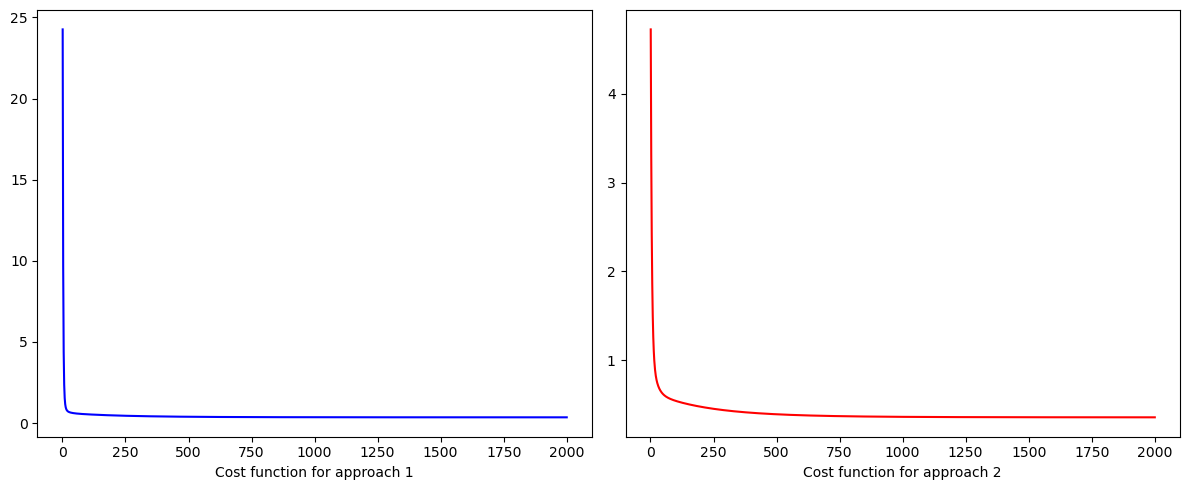

In [191]:
#plot of cost function vs iteration for parts 1 and 2
import matplotlib.pyplot as plt
x=[]
for i in range(1,2001):
    x.append(i)
fig,axes=plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(x,cost_func,color='blue') #for approach 1
axes[0].set_xlabel('Epochs')
axes[0].set_xlabel('Cost function for approach 1')
axes[1].plot(x,cost_func_2,color='red') #for approach 2
axes[1].set_xlabel('Epochs')
axes[1].set_xlabel('Cost function for approach 2')
plt.tight_layout()
plt.show()

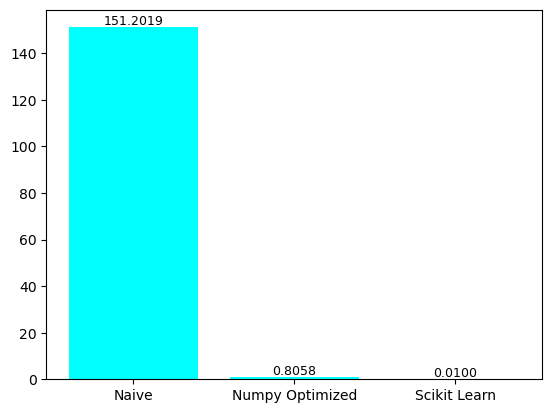

In [193]:
import matplotlib.pyplot as plt
x=np.array(['Naive','Numpy Optimized','Scikit Learn']) #time of convergence compared across all three appraoches(model fitting time for approach 3)
y=np.array([time_1,time_2,time_3])
bars=plt.bar(x,y,color='cyan')
for bar in bars:
    height = bar.get_height()  # Get height of each bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position: center of bar
        height + 0.00000003,                       # Y position: a bit above the bar
        f'{height:.4f}',                    # Text label: formatted as integer
        ha='center', va='bottom', fontsize=9
    )
plt.xlabel
plt.show()

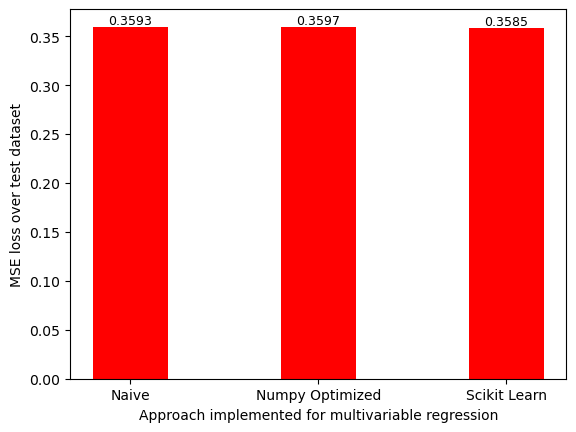

In [195]:
y2=np.array([mse_loss_test_1,mse_loss_test_2,mse_loss_3])
x2=np.array(['Naive','Numpy Optimized','Scikit Learn']) #mse loss compared across all three approaches (over the test dataset)
plt.xlabel('Approach implemented for multivariable regression')
plt.ylabel('MSE loss over test dataset')
bars=plt.bar(x2,y2,color='red',width=0.4)
for bar in bars:
    height = bar.get_height()  # Get height of each bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position: center of bar
        height + 0.00000003,                       # Y position: a bit above the bar
        f'{height:.4f}',                    # Text label: formatted as integer
        ha='center', va='bottom', fontsize=9
    )
plt.show()

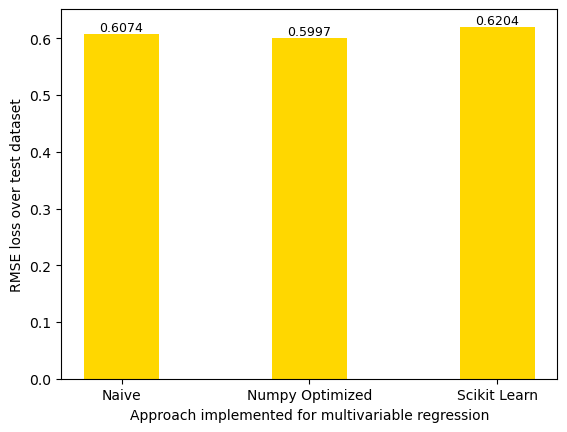

In [197]:
y3=np.array([rmse_loss_test_1,rmse_loss_test_2,rmse_loss_3])
x3=np.array(['Naive','Numpy Optimized','Scikit Learn']) #rmse compared across all three approaches(over the test dataset)
plt.xlabel('Approach implemented for multivariable regression')
plt.ylabel('RMSE loss over test dataset')
bars=plt.bar(x3,y3,color='gold',width=0.4)
for bar in bars:
    height = bar.get_height()  # Get height of each bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position: center of bar
        height + 0.00000003,                       # Y position: a bit above the bar
        f'{height:.4f}',                    # Text label: formatted as integer
        ha='center', va='bottom', fontsize=9
    )
plt.show()

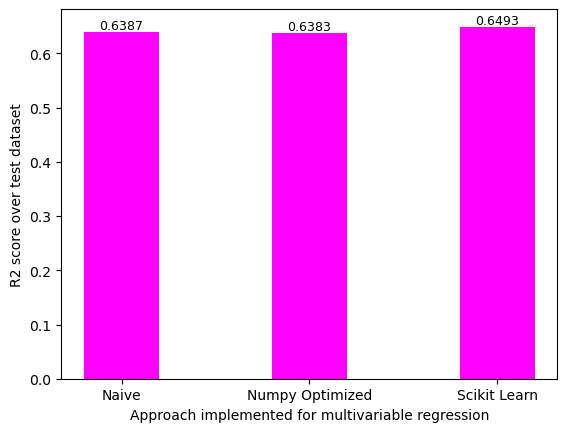

In [199]:
y4=np.array([r2_score_test_1,r_score_test_2,r2_score_val_3])
x4=np.array(['Naive','Numpy Optimized','Scikit Learn']) #r2 score compared across all three appraoches(over the test dataset)
plt.xlabel('Approach implemented for multivariable regression')
plt.ylabel('R2 score over test dataset')
bars=plt.bar(x4,y4,color='magenta',width=0.4)
for bar in bars:
    height = bar.get_height()  # Get height of each bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position: center of bar
        height + 0.00000003,                       # Y position: a bit above the bar
        f'{height:.4f}',                    # Text label: formatted as integer
        ha='center', va='bottom', fontsize=9
    )
plt.show()